# Random Forest Classification – Uber Fare Prediction

## Algorithm Description

This notebook implements the **Random Forest** classification algorithm using a custom-built version from the `rice_ml` package. Random Forest is an ensemble learning method that combines the output of multiple decision trees to improve classification accuracy and robustness.

In our implementation, each decision tree is trained on a different bootstrap sample of the dataset. Predictions from all trees are aggregated using **majority voting** to produce the final class label. This ensemble strategy reduces overfitting and improves generalization.

### How Random Forest Works

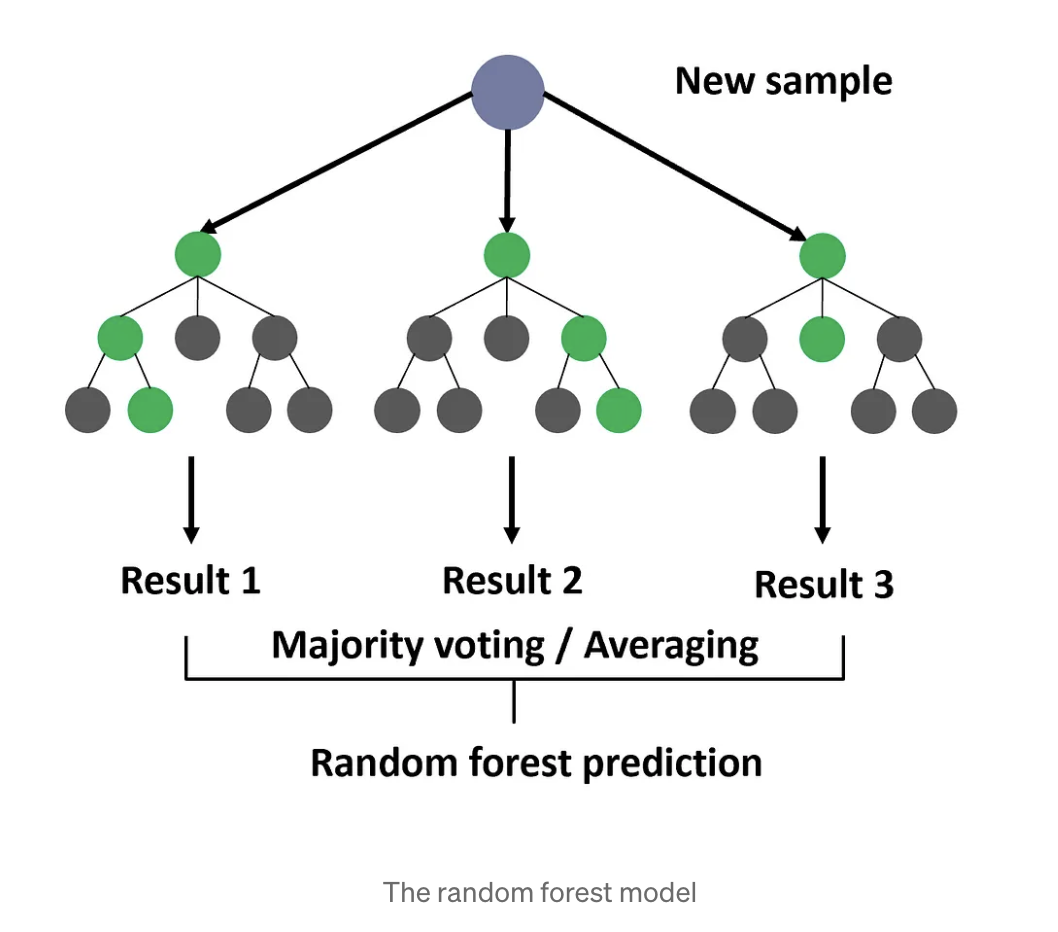

Each decision tree independently predicts the class of a new sample. The final output is determined by majority voting across all trees, which increases stability and accuracy compared to a single decision tree.

Cloning into 'INDE577_ML_Rice_2025'...
remote: Enumerating objects: 314, done.
remote: Counting objects: 100% (314/314), done.
remote: Compressing objects: 100% (244/244), done.
remote: Total 314 (delta 153), reused 160 (delta 63), pack-reused 0 (from 0)
Receiving objects: 100% (314/314), 11.43 MiB | 17.67 MiB/s, done.
Resolving deltas: 100% (153/153), done.
Mounted at /content/drive


<ipython-input-1-91a12d399d1f>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['label'] = (df['fare_amount'] > 15).astype(int)


=== Random Forest Classification ===
Accuracy:  0.9380
Precision: 0.9143
Recall:    0.7191


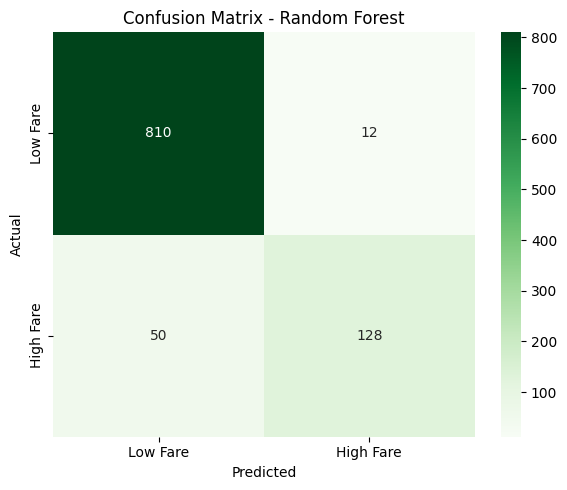

In [1]:
# Step 1: Clone GitHub repo and import Random Forest model
!rm -rf INDE577_ML_Rice_2025
!git clone https://github.com/alicewang777/INDE577_ML_Rice_2025.git

import sys
sys.path.append('/content/INDE577_ML_Rice_2025')

from rice_ml.random_forest import RandomForest
from rice_ml.metrics import accuracy

# Step 2: Mount Drive and load dataset
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, precision_score, recall_score

# Step 3: Load and preprocess Uber fare data
csv_path = "/content/drive/MyDrive/Colab Notebooks/ML_Rice_2025_Final_Project/uber.csv"
df = pd.read_csv(csv_path)

# Filter invalid coordinates and extreme fare values
df = df[(df['pickup_longitude'] != 0) & (df['dropoff_longitude'] != 0)]
df = df[df['fare_amount'] < 100]
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'], errors='coerce')
df = df.dropna()

# Create binary classification label: 1 = High fare (> $15), 0 = Low fare
df['label'] = (df['fare_amount'] > 15).astype(int)

# Sample 5000 rows to reduce computation
df = df.sample(n=5000, random_state=42)

# Feature engineering
df['minute'] = df['pickup_datetime'].dt.minute
df['hour_exact'] = df['pickup_datetime'].dt.hour + df['minute'] / 60.0
df['dayofweek'] = df['pickup_datetime'].dt.dayofweek
df['is_weekend'] = df['dayofweek'].isin([5, 6]).astype(int)
df['hour_exact_x_passenger'] = df['hour_exact'] * df['passenger_count']
df['manhattan_distance'] = (
    np.abs(df['pickup_longitude'] - df['dropoff_longitude']) +
    np.abs(df['pickup_latitude'] - df['dropoff_latitude'])
)

features = [
    'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
    'passenger_count', 'hour_exact', 'dayofweek', 'is_weekend',
    'hour_exact_x_passenger', 'manhattan_distance'
]

X_raw = df[features].values
y = df['label'].values

# Step 4: Scale features and split data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_raw)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Step 5: Train Random Forest model
rf_model = RandomForest(n_estimators=15, max_depth=6, min_samples_split=10, sample_ratio=0.8)
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)

# Step 6: Evaluate model performance
acc = accuracy(y_test, y_pred)
prec = precision_score(y_test, y_pred, zero_division=0)
rec = recall_score(y_test, y_pred, zero_division=0)

print("=== Random Forest Classification ===")
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")

# Step 7: Visualize confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Greens", xticklabels=["Low Fare", "High Fare"], yticklabels=["Low Fare", "High Fare"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Random Forest")
plt.tight_layout()
plt.show()


# **Model Performance Interpretation – Random Forest**

The Random Forest model achieves an **accuracy of 93.8%**, indicating strong overall performance in classifying Uber rides into low fare and high fare categories. The **precision of 91.43%** suggests that when the model predicts a ride to be high fare, it is correct over 91% of the time—demonstrating a low false positive rate. The **recall of 71.91%** means that the model successfully identifies nearly 72% of all actual high-fare trips. From the confusion matrix:

- **True Negatives (810):** Most low-fare rides are correctly classified.

- **True Positives (128):** A substantial portion of high-fare rides are also correctly detected.

- **False Negatives (50):** Some high-fare rides are missed and predicted as low fare.

- **False Positives (12):** Only a small number of low-fare rides are incorrectly flagged as high fare.

Overall, this model balances precision and recall well and is particularly effective at minimizing incorrect high-fare predictions, which is valuable in high-stakes or cost-sensitive applications. Further improvements could focus on reducing false negatives to capture more high-fare rides without sacrificing precision.